<a href="https://colab.research.google.com/github/CT-6282/COVID-19_Paper/blob/master/covid_train_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import joblib
sns.set(color_codes=True)
from sklearn.pipeline import Pipeline

In [47]:
print(os.getcwd())
df = pd.read_csv("covid_data.csv.zip")
df.head

/content


<bound method NDFrame.head of         ENTIDAD_UM  SEXO  ENTIDAD_NAC  ...  DIAS_DIF_HOSP  BOOL_DEF  DIAS_DIF_DEF
0               27     0           27  ...              5         0             0
1                2     0            8  ...             12         0             0
2                2     0           11  ...              7         0             0
3               15     1           15  ...              3         0             0
4                9     0            9  ...              4         0             0
...            ...   ...          ...  ...            ...       ...           ...
940083          25     1           25  ...              6         0             0
940084          27     1            7  ...              3         0             0
940085           9     1            9  ...              4         0             0
940086          30     1           30  ...              2         0             0
940087           9     0            9  ...              7         0 

In [48]:
#%%10% de los datos aleatorios
df = df.sample(frac=0.01)
df.head

<bound method NDFrame.head of         ENTIDAD_UM  SEXO  ENTIDAD_NAC  ...  DIAS_DIF_HOSP  BOOL_DEF  DIAS_DIF_DEF
61554           13     1           13  ...             10         0             0
184727          24     0           24  ...              2         0             0
753544          26     1           26  ...              7         0             0
122645          21     0           21  ...              9         1            23
563577          29     1           30  ...              6         0             0
...            ...   ...          ...  ...            ...       ...           ...
619471           9     0            9  ...              3         1             4
119797           9     1            9  ...              9         0             0
539483          15     0            9  ...              3         0             0
208243           9     0            9  ...              0         0             0
845026          11     0           11  ...              3         0 

In [49]:
#%%Valida si existen las carpetas
try:
    os.makedirs("plots")
    os.makedirs("models")
except FileExistsError:
    pass

In [50]:
# %%pca
class pca():
    def __init__(self,  df=None, titulo="Unspecified", label_y=None):
        self.df = df
        self.label_y = str(label_y)
        self.titulo = str(titulo)
        print(list(df))
        print(f"Numero de elementos de {label_y}\n", df[label_y].value_counts())
    def pca_2D(self):
        df_PCA = self.df.drop([self.label_y], axis=1)
        #instanciamos el metodo pca con 2 componentes
        pca = PCA(n_components=2)
        #encontramos los componentes principales usando 
        #el método de ajuste con 2 componentes
        #transformamos los datos scaled_data en 2 componentes con pca
        pca.fit(df_PCA)
        x_pca = pca.transform(df_PCA)
        ######
        #instanciamos un objeto para hacer PCA
        scaler = StandardScaler()
        #escalar los datos, estandarizarlos, para que cada
        #caracteristica tenga una varianza unitaria 
        scaler.fit(df_PCA)
        #aplicamos la reducción de rotación y dimensionalidad
        scaled_data = scaler.transform(df_PCA)
        pca = PCA().fit(scaled_data)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.title('How many components are needed to describe the data.')
        ######
        print("Dimension de los features orginales: ", df_PCA.shape)
        print("Dimension de los features con 2 componentes", x_pca.shape)
        
        #visualizar los datos en 2 dimensiones
        #plt.figure(figsize=(8,6))
        fig, ax = plt.subplots()
        scatter = plt.scatter(x_pca[:,0],
                    x_pca[:,1],
                    c=self.df[self.label_y],
                    cmap='rainbow',
                    marker='o',
                    s=2,
                    linewidths=0)
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".", ls="", 
                              color=scatter.cmap(scatter.norm(yi))) for yi in labels]
        plt.legend(handles, labels)
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')
        plt.title(self.titulo)
        #plt.show()
        plt.savefig("plots/"+self.titulo + "_2D.png",format='png', dpi=1200)
        y = self.df[self.label_y]
        return x_pca, y
    def pca_3D(self):
        sns.set_style("white")  
        self.df[self.label_y] = pd.Categorical(self.df[self.label_y])
        my_color = self.df[self.label_y].cat.codes
        df_PCA = self.df.drop([self.label_y], axis=1)
        pca = PCA(n_components=3)
        pca.fit(df_PCA)
        result=pd.DataFrame(pca.transform(df_PCA), 
                            columns=['PCA%i' % i for i in range(3)], 
                            index=df_PCA.index)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scat = ax.scatter(result['PCA0'], 
                   result['PCA1'], 
                   result['PCA2'], 
                   c=my_color, 
                   cmap='rainbow', 
                   s=2, marker="o",
                   linewidths=0)
        
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".",ls="",
                                 color=scat.cmap(scat.norm(yi))) for yi in labels]               
        ax.legend(handles, labels)
        
        # make simple, bare axis lines through space:
        xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
        ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
        yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
        ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
        zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
        ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
         
        # label the axes
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title(self.titulo)
        #plt.show()
        fig.tight_layout()
        plt.savefig("plots/"+self.titulo + "_3D.png", format='png', dpi=1200)
        y = self.df[self.label_y]
        return result, y

In [41]:
#%%solamente
def solamente(df, columna, bool=None):
    if bool == None:
        bool = 1
    df = df[df[columna] == bool] #filtrar
    df.drop([columna], axis=1, inplace = True)
    return df

In [51]:
#%%gridsearchcv
#checar stratify
def gridsearchcv(X, y, n_pca=None):
    if n_pca != None:
        X_train, X_test, Y_train, Y_test = train_test_split(X,y,
                                                            test_size=0.2, 
                                                            #stratify=y, 
                                                            #random_state=False,
                                                            shuffle=True)
        pipe_steps = [('scaler', StandardScaler()),('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]
        param_grid= {
            'pca__n_components': [n_pca], 
            'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
            'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
        }
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(X,y,
                                                    test_size=0.2, 
                                                    #stratify=y, 
                                                    #random_state=False,
                                                    shuffle=True)
        pipe_steps = [('scaler', StandardScaler()), ('SupVM', SVC(kernel='rbf'))]
        param_grid= {
            'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
            'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
        }
    pipeline = Pipeline(pipe_steps)
    grid = GridSearchCV(pipeline, param_grid,refit = True,verbose = 3, n_jobs=-1)
    grid.fit(X_train, Y_train)
    print ("Best-Fit Parameters From Training Data:\n",grid.best_params_)
    grid_predictions = grid.predict(X_test) 
    report = classification_report(Y_test, grid_predictions, output_dict=True)
    report = pd.DataFrame(report).transpose()
    print(report)
    print(confusion_matrix(Y_test, grid_predictions))
    return grid, report, X_test, Y_test

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


['EDAD', 'EMBARAZO', 'RENAL_CRONICA', 'DIABETES', 'INMUSUPR', 'EPOC', 'OBESIDAD', 'OTRO_CASO', 'HIPERTENSION', 'TABAQUISMO', 'CARDIOVASCULAR', 'ASMA', 'SEXO', 'TIPO_PACIENTE']
Numero de elementos de TIPO_PACIENTE
 0    2932
1    1137
Name: TIPO_PACIENTE, dtype: int64
Dimension de los features orginales:  (4069, 13)
Dimension de los features con 2 componentes (4069, 2)


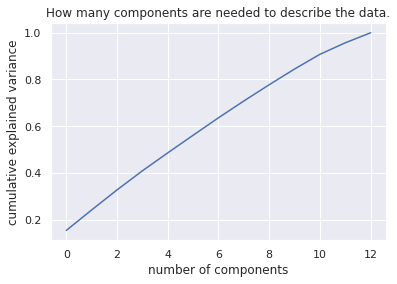

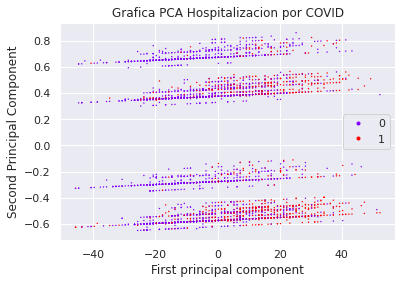

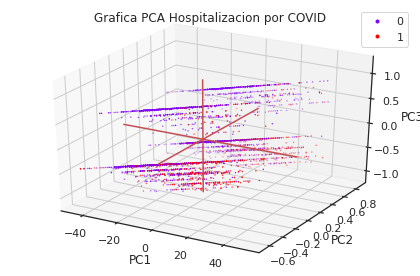

In [52]:
#%%prediccion de hospitalizacion por covid - PCA
hosp_data = df.copy()
hosp_data = solamente(hosp_data,'RESULTADO')
hosp_data = hosp_data.loc[:,['EDAD','EMBARAZO','RENAL_CRONICA','DIABETES','INMUSUPR','EPOC','OBESIDAD','OTRO_CASO','HIPERTENSION','TABAQUISMO','CARDIOVASCULAR','ASMA','SEXO','TIPO_PACIENTE']]
hosp_data = hosp_data.reset_index(drop=True)
#visualizacion pca
hosp_pca = pca(hosp_data, titulo="Grafica PCA Hospitalizacion por COVID", label_y="TIPO_PACIENTE")
hosp_pca.pca_2D(); hosp_pca.pca_3D()
#separar datos
X = hosp_data.loc[:, hosp_data.columns != 'TIPO_PACIENTE']
y = hosp_data.loc[:,'TIPO_PACIENTE']

In [ ]:
#---->train
#hosp_data_grid, hosp_data_grid_report, X_test, Y_test = gridsearchcv(X,y, n_pca=2)
hosp_data_grid, hosp_data_grid_report, X_test, Y_test = gridsearchcv(X,y, n_pca=None)
#guarda el modelo y su reporte
#joblib.dump(hosp_data_svm.best_estimator_, 'models/hosp_data_svm.pkl', compress = 1)
joblib.dump(hosp_data_grid, 'models/hosp_data_grid.pkl', compress = 1)
hosp_data_grid_report.to_csv("models/hosp_data_grid_report.csv", index=True)
#importa el modelo y su rendimiento
hosp_data_grid_load = joblib.load('models/hosp_data_grid.pkl')
hosp_data_grid_report = pd.read_csv("models/hosp_data_grid_report.csv", index_col=0)
#prueba el modelo load con input sin preprocesamiento
Y_test.iloc[20]
hosp_data_grid_load.predict(X_test.iloc[20,:].values.reshape(1,-1)) 

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  3.9min
